In [1]:
import sys
import os
import time
sys.path.append("/u/li19/diffusers_with_dataloader/examples/audio_generation/audio_gen_files")
from AudiosetDataset import AudiosetDataset
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import AutoTokenizer, T5EncoderModel,T5TokenizerFast
from encodec import EncodecModel
import IPython.display as ipd
import random
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
import json
import numpy as np
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm
import csv
# device = "cuda"
# device = "cpu"

In [2]:
device = "cuda"

In [3]:

# tokenizer = AutoTokenizer.from_pretrained("cvssp/audioldm-m-full", model_max_length=512,  subfolder="tokenizer")
# text_encoder = T5EncoderModel.from_pretrained("cvssp/audioldm-m-full", subfolder="text_encoder")

tokenizer = AutoTokenizer.from_pretrained("t5-large", model_max_length=52)
text_encoder = T5EncoderModel.from_pretrained("t5-large")
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)
model = model.to(device)

Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.3.layer.1.EncDecAttention.v.weight', 'decoder.block.15.layer.1.EncDecAttention.q.weight', 'decoder.block.13.layer.0.SelfAttention.k.weight', 'decoder.block.3.layer.0.layer_norm.weight', 'decoder.block.19.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.0.layer_norm.weight', 'decoder.block.23.layer.0.SelfAttention.k.weight', 'decoder.block.14.layer.1.EncDecAttention.v.weight', 'decoder.block.17.layer.0.SelfAttention.q.weight', 'decoder.block.8.layer.1.EncDecAttention.k.weight', 'decoder.block.20.layer.0.SelfAttention.o.weight', 'decoder.block.12.layer.0.SelfAttention.q.weight', 'decoder.block.22.layer.2.layer_norm.weight', 'decoder.block.3.layer.2.DenseReluDense.wo.weight', 'decoder.block.13.layer.0.layer_norm.weight', 'decoder.block.14.layer.0.layer_norm.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.7.layer.2.DenseReluDense.wo.weight', 'd

In [4]:

batch_size = 192
bal_sampling = True

# bal_audio_conf = "/u/li19/diffusers_with_dataloader/examples/audio_generation/audio_gen_files/audio_conf_latents.json"
# with open(bal_audio_conf, "r") as f:
#     audio_set_data_file = json.load(f)
# unbal_bal_audio_conf = "/u/li19/diffusers_with_dataloader/examples/audio_generation/audio_gen_files/unbal_bal_audio_conf_latents-tmp.json"

strong_audio_conf = "/u/li19/diffusers_with_dataloader/examples/audio_generation/audio_gen_files/audio_conf_latent_formant_strong.json"

with open(strong_audio_conf, "r") as f:
    audio_set_data_file = json.load(f)

dataset = AudiosetDataset(
    audio_set_data_file, 
    device=device,
    tokenizer = tokenizer,
    dtype=torch.float32,
    channels=1,
    mixup_ratio = 1,
    mixup_type='strong',
    n_mixup = 2
)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)
if bal_sampling:
    samples_weight = np.loadtxt(audio_set_data_file['weight_path'], delimiter=',')
    print("Using Balanced Sampler, loading weights from: ", audio_set_data_file['weight_path'])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
    train_dataloader = torch.utils.data.DataLoader(dataset,
        batch_size = batch_size, sampler=sampler, num_workers=0)
else:
    sampler=None
    train_dataloader = torch.utils.data.DataLoader( 
            dataset,
            batch_size = batch_size, sampler=sampler, num_workers=0, shuffle=True)


Using Balanced Sampler, loading weights from:  /u/li19/data_folder/AudioTaggingDoneRight/egs/audioset/data/datafiles/alpaca_bal_unbal_weight.csv


In [5]:
iter_data = iter(train_dataloader)

In [6]:
batch = next(iter_data)

 a person is listening to the waves crashing on the beach with the wind rustling the nearby trees. , followed by sound of Male speech, man speaking


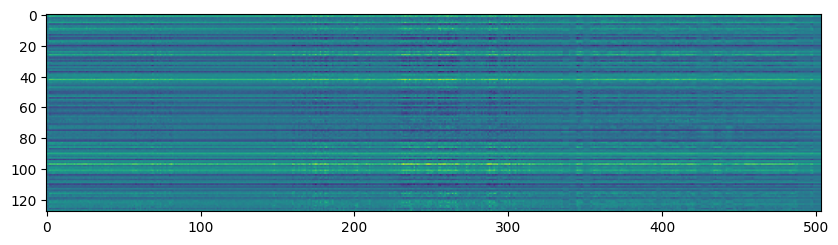

In [15]:
idx =4
embed = model.quantizer.decode(batch['latent'][idx].transpose(0,1).to(device, dtype=torch.int64))
wav = model.decoder(embed)
print(batch['caption'][idx])
plt.figure(figsize=(10, 6))
plt.imshow(embed[0].cpu().numpy())
ipd.Audio(wav.cpu().detach().numpy()[0], rate=16_000)


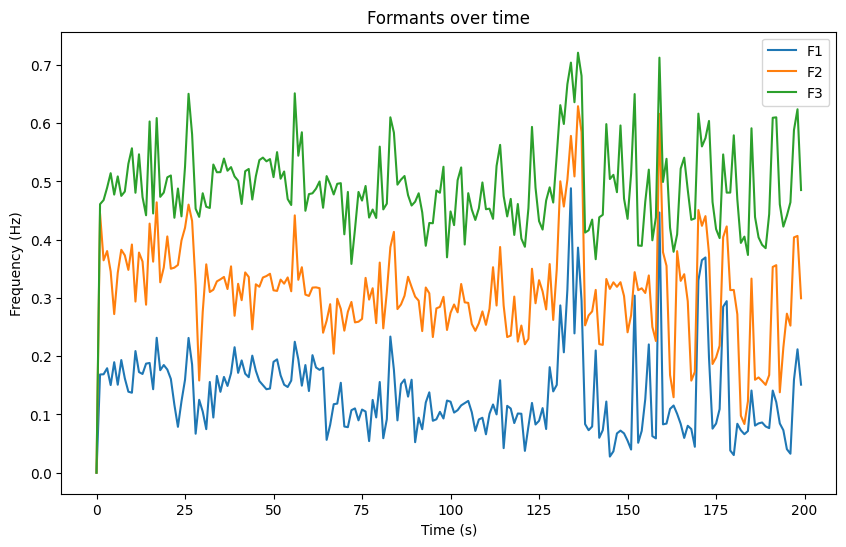

In [16]:
formants = batch['formant'][idx]
plt.figure(figsize=(10, 6))
plt.plot( formants[0, :], label='F1')
plt.plot(formants[1, :], label='F2')
plt.plot(formants[2, :], label='F3')
plt.title('Formants over time')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

In [9]:
print(formants)

tensor([[0.0000, 0.1495, 0.2464, 0.1970, 0.2509, 0.1875, 0.1679, 0.1745, 0.1829,
         0.1768, 0.1779, 0.1772, 0.1761, 0.1897, 0.1882, 0.1767, 0.1766, 0.1798,
         0.2615, 0.2666, 0.2761, 0.2606, 0.2810, 0.2528, 0.2697, 0.2843, 0.2036,
         0.2256, 0.2098, 0.1793, 0.1323, 0.1795, 0.2091, 0.1217, 0.1633, 0.1582,
         0.1248, 0.1416, 0.1199, 0.1421, 0.1234, 0.1852, 0.1343, 0.1453, 0.1458,
         0.1335, 0.1282, 0.1422, 0.1853, 0.1419, 0.1676, 0.2097, 0.1346, 0.1345,
         0.1642, 0.1404, 0.1414, 0.1697, 0.1336, 0.1342, 0.1401, 0.1589, 0.1977,
         0.1746, 0.2244, 0.1844, 0.2316, 0.1945, 0.2226, 0.2379, 0.2381, 0.2060,
         0.2241, 0.1773, 0.2067, 0.1878, 0.1899, 0.1822, 0.1968, 0.1869, 0.1892,
         0.1750, 0.1747, 0.1851, 0.1789, 0.1723, 0.1621, 0.1595, 0.1759, 0.1816,
         0.1835, 0.2239, 0.1593, 0.2010, 0.2120, 0.2064, 0.1987, 0.1978, 0.1970,
         0.1994, 0.1742, 0.2111, 0.1682, 0.1537, 0.1443, 0.1653, 0.1657, 0.1518,
         0.1469, 0.1630, 0.1

In [10]:
import torch.nn.functional as F
mean_formants = []
min_formants = 0
max_formants = 0
std_formants = []
for ind, batch in tqdm(enumerate(train_dataloader), total=len(samples_weight)//batch_size):
    if ind > 1000:
        break
    formants_batch = batch['formant']
    nan_mask = torch.isnan(formants_batch)
    formants_batch[nan_mask] = 0
    min_formants = min(torch.min(formants_batch).item(), min_formants)
    max_formants = max(torch.max(formants_batch).item(), max_formants)
    mean_formants.append(torch.mean(formants_batch).item())
    std_formants.append(torch.std(formants_batch).item())


  0%|          | 38/10521 [00:11<50:48,  3.44it/s] 


KeyboardInterrupt: 

In [ ]:
print("min:", min_formants, "max:", max_formants,  "mean:",np.mean(mean_formants), "std:",np.mean(std_formants))


In [ ]:
print(formants_batch.shape)

In [ ]:
print(normalized_formants)

In [ ]:
mean_len = []
min_len = 0
max_len = 0
for ind, batch in tqdm(enumerate(train_dataloader), total=len(samples_weight)//batch_size):
    if ind > 100:
        break
    # print(batch['caption'])
    # print(batch['input_ids'])
    token_lens = [torch.nonzero(datum).size(0) for datum in batch['input_ids']]
    min_len, max_len = min(token_lens), max(token_lens)
    mean_len+=token_lens
print(min_len, max_len)
print(sum(mean_len)/len(mean_len))

In [ ]:
print(batch['caption'])

In [34]:
print(batch['input_ids'])

tensor([[    3,     9,   568,    19,  1556,     3,     9,  4183,  5009,   298,
          2508,    28,   841,  1307,     5,     1,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [ 2449,    33,  6723,    16,     3,     9,  3432,    30,     3,     9,
          4033,   416,    12,     3,     9,  1689,    30,     3,     9,  1373,
           298,   430,  1689,  9016,    57,     5,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [    3,     9,   568,  3011,     7,    12,   723,   298,     3,     9,
          1345,  1504,    13, 26783,     6,  2943,     6,    11,  3412,    54,
    

In [51]:
torch.nonzero(batch['input_ids'][0]).size()

torch.Size([16, 1])

In [54]:
attention_mask= batch['attn_mask'][0]
print(attention_mask)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


In [55]:
torch.nonzero(batch['attn_mask'][0]).size()

torch.Size([16, 1])

In [66]:
encoder_hidden_states_masked = text_encoder(batch["input_ids"], attention_mask= batch['attn_mask'])

In [74]:
print(encoder_hidden_states_masked[0])

tensor([[[-4.1808e-01, -3.4356e-02, -2.4830e-02,  ...,  7.7408e-02,
          -1.5910e-01, -4.2744e-02],
         [-2.2405e-01,  1.5324e-01, -2.5651e-01,  ...,  2.2653e-01,
           2.3793e-01,  1.7721e-01],
         [-1.5349e-01,  9.4758e-02, -3.1459e-01,  ...,  2.0134e-01,
           5.8699e-03,  2.5948e-02],
         ...,
         [-2.7741e-01,  6.8650e-02,  1.6961e-01,  ...,  7.7376e-02,
          -8.2082e-02,  2.4541e-01],
         [-2.7045e-01,  4.6031e-02,  1.5495e-01,  ...,  1.2343e-01,
          -8.1371e-02,  2.2767e-01],
         [-2.6709e-01,  4.5302e-02,  1.6349e-01,  ...,  1.2451e-01,
          -8.7501e-02,  2.2269e-01]],

        [[-7.1263e-02,  1.3057e-01,  5.8424e-02,  ...,  2.9805e-01,
           2.5963e-01, -1.1873e-01],
         [-1.1801e-01, -2.3346e-01, -1.5485e-01,  ...,  3.7689e-02,
           5.9254e-02,  7.6865e-02],
         [ 4.0982e-02,  3.2563e-02, -2.3497e-01,  ..., -1.7300e-01,
          -5.0856e-02,  9.4221e-02],
         ...,
         [ 5.0516e-02,  5

In [72]:
encoder_hidden_states_unmasked = text_encoder(batch["input_ids"])

In [75]:
print(encoder_hidden_states_unmasked[0])

tensor([[[-0.4625,  0.0833, -0.0132,  ...,  0.0913, -0.0856, -0.0470],
         [-0.5140, -0.0322, -0.3528,  ...,  0.1862,  0.1365,  0.0233],
         [-0.2137,  0.1241, -0.3057,  ...,  0.2616, -0.0913, -0.0648],
         ...,
         [-0.0589, -0.5167, -0.1990,  ...,  0.2622, -0.2767,  0.0197],
         [-0.1223, -0.4163, -0.1340,  ...,  0.3299, -0.2073,  0.0031],
         [-0.1688, -0.2404, -0.0251,  ...,  0.1318, -0.2712, -0.0983]],

        [[-0.2066,  0.1028,  0.0765,  ...,  0.3547,  0.3662, -0.0992],
         [-0.1328, -0.2071, -0.1854,  ..., -0.0080,  0.1426,  0.0343],
         [-0.0825,  0.1134, -0.1732,  ..., -0.2053,  0.0294, -0.0076],
         ...,
         [-0.1279, -0.3957, -0.2658,  ...,  0.1774, -0.2321,  0.0448],
         [-0.1149, -0.3647, -0.2274,  ...,  0.2649, -0.1959,  0.0405],
         [-0.1539, -0.3564, -0.0784,  ..., -0.0065, -0.1130,  0.1088]],

        [[-0.3855, -0.0485, -0.2327,  ...,  0.1172, -0.0597, -0.1981],
         [-0.1903, -0.0698, -0.1966,  ...,  0

In [15]:
name_path = "/u/li19/diffusers_with_dataloader/examples/audio_generation/audio_gen_files/mid_to_display_name.tsv"
tsv_file = open(name_path, 'r')
reader = csv.reader(tsv_file, delimiter="\t")
name_data = {}
for line in reader:
    name_data[line[0]] = line[1]

In [16]:
fpath = "/u/li19/data_folder/AudioTaggingDoneRight/egs/audioset/data/datafiles/alpaca_av_bal_unbal_train.json"

with open(fpath, 'r') as f:
    data = json.load(f)["data"]
    
print(len(data))

2020106


In [17]:
look_up = {datum['wav'].split("/")[-1].split(".")[0]: datum for datum in data}

In [18]:
look_up['b0RFKhbpFJA']

{'wav': '/u/li19/data_folder/audioSetAudio/unbalanced_wav/b0RFKhbpFJA.wav',
 'labels': '/m/01h3n,/m/03vt0,/m/09x0r',
 'caption': ' a bee and a wasp are buzzing in the air as people are talking. ',
 'classes': ['Bee, wasp, etc.', 'Insect', 'Speech'],
 'av_caption': 'a bee and a wasp are buzzing in the air as people are talking.'}

In [19]:
strongdir = "/u/li19/diffusers_with_dataloader/examples/audio_generation/audio_gen_files/audioset_train_strong.tsv"
tsv_file = open(strongdir, 'r')
reader = csv.DictReader(tsv_file, delimiter="\t")
strong_data = list()
for dictionary in reader:
    dictionary['youtube_id'] = dictionary['segment_id'][:11]
    dictionary['start_time_seconds'] = float(dictionary['start_time_seconds'])
    dictionary['end_time_seconds'] = float(dictionary['end_time_seconds'])
    dictionary['length'] = dictionary['end_time_seconds'] - dictionary['start_time_seconds']
    
    dictionary['name'] = name_data[dictionary['label']]
        
    if (dictionary['youtube_id'] in look_up.keys()):
        strong_data.append(dictionary)

In [20]:
strong_data[0]

{'segment_id': 'b0RFKhbpFJA_30000',
 'start_time_seconds': 0.0,
 'end_time_seconds': 10.0,
 'label': '/m/03m9d0z',
 'youtube_id': 'b0RFKhbpFJA',
 'length': 10.0,
 'name': 'Wind'}

In [21]:
with open("audioset_strong_train_filtered.tsv", 'w') as f:
    f.write("segment_id\tstart_time_seconds\tend_time_seconds\tlabel\tname\tyoutube_id\n")
    for line in strong_data:
        
        str_line = f"{line['segment_id']}\t{line['start_time_seconds']}\t{line['end_time_seconds']}\t{line['label']}\t{line['name']}\t{line['youtube_id']}\n"
        
        f.write(str_line)

In [22]:
len(strong_data)

876414

In [3]:
max_files = 2000000
directory = "/u/li19/data_folder/audioSetAudio/formants/output"
files = os.listdir(directory)

In [4]:
print(len(os.listdir(directory)))

2020713


In [5]:
targ = '5YisuEUQcqg'
for f in files:
    if targ in f:
        print(f)

5YisuEUQcqg.npy


In [6]:
data = np.load("/u/li19/data_folder/audioSetAudio/formants/output/5YisuEUQcqg.npy")
print(data.shape)

(3, 200)
